In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = 16,8

import warnings
warnings.filterwarnings('ignore')


import re
from konlpy.tag import Okt, Mecab
from ckonlpy.tag import Twitter
from hanspell import spell_checker
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import nltk
nltk.download('stopwords')

# -------
stopword = pd.read_csv('data/stopword.csv')
stopword = stopword.iloc[:,0].tolist()

import pickle
with open( "data/add_user_dictionary.pickle", "rb" ) as file:
    add_dict = pickle.load(file)
    
with open('data/remove_6.pickle','rb') as file:
    rem6 = pickle.load(file)
    
remove6 = [w for w in rem6 if not w in add_dict] # 사용자단어에 추가된 단어는 제외함

twitter = Twitter()
# 특정 단어 추가
twitter.add_dictionary(add_dict, 'Noun')

m = Mecab(r'C:/mecab/mecab-ko-dic')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cv002\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import pickle

with open( "data/remove_6.pickle", "wb" ) as file:
    pickle.dump(rem6, file)    

## 데이터 불러오기

In [3]:
tag_df = pd.read_json('data/0917_tag_konlpy.json')
title_to_tag_df = pd.read_json('data/0917_title_to_tag_konlpy.json')

In [4]:
tag_df.reset_index(inplace=True)
tag_df

,index,tagss
0,0,[락]
1,1,"[추억, 회상]"
2,2,"[카페, 잔잔]"
3,3,"[연말, 눈, 날, 캐럴, 분위기, 따듯, 크리스마스, 캐럴, 겨울, 노래, 크리스..."
4,4,[댄스]
...,...,...
115066,115066,"[록, 메탈, 밴드, 사운드, 록, 락, 메탈, 메탈, 락, extreme]"
115067,115067,[일렉]
115068,115068,"[담시, 가족, 눈물, 그리움, 주인공, 이야기, 사랑, 친구]"
115069,115069,"[잔잔, 버스, 퇴근, 버스, pop, 풍경, 퇴근길]"


In [5]:
title_to_tag_df.reset_index(inplace=True)
title_to_tag_df

,index,title_to_tag
0,0,"[여행, 음악]"
1,1,[요즘]
2,2,"[편하, 잔잔, 곡]"
3,3,"[크리스마스, 분위기, 취하]"
4,4,"[추억, 노래]"
...,...,...
115066,115066,"[metal, e, sm, 2]"
115067,115067,"[빠른, 리스, 위, 최신, 인기, edm, 모음]"
115068,115068,"[1, 눈물, 가리, 이야기]"
115069,115069,"[퇴근, 버스, 하루, 마무리, pop]"


Doc2Vec의 결과를 보면 
단어 수를 줄이는게 좋을 듯 해보임



## 데이터 합쳐서 새로운 태그로 만들기

In [6]:
total = pd.merge(tag_df,title_to_tag_df, on='index', how='left')
total['new_word_tag'] = total['tagss'] + total['title_to_tag']
total.drop('index',axis=1,inplace=True)
total

,tagss,title_to_tag,new_word_tag
0,[락],"[여행, 음악]","[락, 여행, 음악]"
1,"[추억, 회상]",[요즘],"[추억, 회상, 요즘]"
2,"[카페, 잔잔]","[편하, 잔잔, 곡]","[카페, 잔잔, 편하, 잔잔, 곡]"
3,"[연말, 눈, 날, 캐럴, 분위기, 따듯, 크리스마스, 캐럴, 겨울, 노래, 크리스...","[크리스마스, 분위기, 취하]","[연말, 눈, 날, 캐럴, 분위기, 따듯, 크리스마스, 캐럴, 겨울, 노래, 크리스..."
4,[댄스],"[추억, 노래]","[댄스, 추억, 노래]"
...,...,...,...
115066,"[록, 메탈, 밴드, 사운드, 록, 락, 메탈, 메탈, 락, extreme]","[metal, e, sm, 2]","[록, 메탈, 밴드, 사운드, 록, 락, 메탈, 메탈, 락, extreme, met..."
115067,[일렉],"[빠른, 리스, 위, 최신, 인기, edm, 모음]","[일렉, 빠른, 리스, 위, 최신, 인기, edm, 모음]"
115068,"[담시, 가족, 눈물, 그리움, 주인공, 이야기, 사랑, 친구]","[1, 눈물, 가리, 이야기]","[담시, 가족, 눈물, 그리움, 주인공, 이야기, 사랑, 친구, 1, 눈물, 가리,..."
115069,"[잔잔, 버스, 퇴근, 버스, pop, 풍경, 퇴근길]","[퇴근, 버스, 하루, 마무리, pop]","[잔잔, 버스, 퇴근, 버스, pop, 풍경, 퇴근길, 퇴근, 버스, 하루, 마무리..."


### 새로운 태그 저장

In [7]:
total.to_json('data/0917_new_tag.json', orient = 'records')

---
---
---
## 필요없는 태그 지우기 

In [8]:
new_tag = total.copy()
new_tag

,tagss,title_to_tag,new_word_tag
0,[락],"[여행, 음악]","[락, 여행, 음악]"
1,"[추억, 회상]",[요즘],"[추억, 회상, 요즘]"
2,"[카페, 잔잔]","[편하, 잔잔, 곡]","[카페, 잔잔, 편하, 잔잔, 곡]"
3,"[연말, 눈, 날, 캐럴, 분위기, 따듯, 크리스마스, 캐럴, 겨울, 노래, 크리스...","[크리스마스, 분위기, 취하]","[연말, 눈, 날, 캐럴, 분위기, 따듯, 크리스마스, 캐럴, 겨울, 노래, 크리스..."
4,[댄스],"[추억, 노래]","[댄스, 추억, 노래]"
...,...,...,...
115066,"[록, 메탈, 밴드, 사운드, 록, 락, 메탈, 메탈, 락, extreme]","[metal, e, sm, 2]","[록, 메탈, 밴드, 사운드, 록, 락, 메탈, 메탈, 락, extreme, met..."
115067,[일렉],"[빠른, 리스, 위, 최신, 인기, edm, 모음]","[일렉, 빠른, 리스, 위, 최신, 인기, edm, 모음]"
115068,"[담시, 가족, 눈물, 그리움, 주인공, 이야기, 사랑, 친구]","[1, 눈물, 가리, 이야기]","[담시, 가족, 눈물, 그리움, 주인공, 이야기, 사랑, 친구, 1, 눈물, 가리,..."
115069,"[잔잔, 버스, 퇴근, 버스, pop, 풍경, 퇴근길]","[퇴근, 버스, 하루, 마무리, pop]","[잔잔, 버스, 퇴근, 버스, pop, 풍경, 퇴근길, 퇴근, 버스, 하루, 마무리..."


In [9]:
# 중복 태그 지우기
X = [list(set(x)) for x in new_tag['new_word_tag']]
new_tag['no_du'] = X
new_tag = new_tag[['no_du']]
new_tag

,no_du
0,"[여행, 음악, 락]"
1,"[추억, 요즘, 회상]"
2,"[곡, 카페, 잔잔, 편하]"
3,"[따듯, 겨울, 눈, 연말, 크리스마스, 노래, 송, 취하, 날, 분위기, 왕국, 캐럴]"
4,"[추억, 댄스, 노래]"
...,...
115066,"[록, 사운드, e, 메탈, sm, metal, 2, 밴드, extreme, 락]"
115067,"[모음, 최신, 일렉, 리스, edm, 위, 인기, 빠른]"
115068,"[1, 주인공, 가족, 친구, 그리움, 가리, 담시, 눈물, 사랑, 이야기]"
115069,"[잔잔, 퇴근길, 풍경, 버스, 마무리, 퇴근, pop, 하루]"


In [10]:
unnest = np.dstack(
    (np.repeat(new_tag.index.values,list(map(len,new_tag.no_du))),
     np.concatenate(new_tag.no_du.values))
         )

unnest_df = pd.DataFrame(unnest[0],columns = ['id','no_du'])

ddf = pd.DataFrame(unnest_df['no_du'].value_counts())
ddf.reset_index(inplace=True)
ddf.columns = ['no_du','cnt']
ddf['len'] = ddf['no_du'].apply(lambda x:len(x))
ddf['1'] = 1
ddf

,no_du,cnt,len,1
0,노래,21434,2,1
1,감성,17148,2,1
2,기분전환,16700,4,1
3,듣,16065,1,1
4,음악,15413,2,1
...,...,...,...,...
24792,160501,1,6,1
24793,콘체르토,1,4,1
24794,서럽,1,2,1
24795,bassmentjaxx,1,12,1


In [41]:
ddf.query('cnt >= 7')['cnt'].sum()

848297

In [12]:
ddf.describe()

,cnt,len,1
count,24797.000000,24797.000000,24797.0
mean,35.667056,3.712223,1.0
std,394.330740,2.520591,0.0
min,1.000000,1.000000,1.0
25%,1.000000,2.000000,1.0
50%,2.000000,3.000000,1.0
75%,6.000000,4.000000,1.0
max,21434.000000,25.000000,1.0


In [11]:
ddf.query('no_du == "아이유"')

,no_du,cnt,len,1
455,아이유,257,3,1


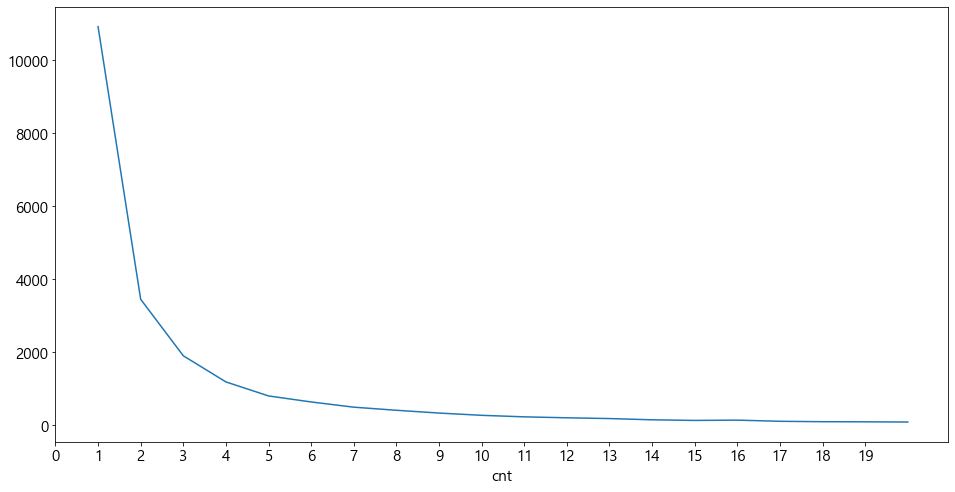

In [80]:
# 빈도수에 대한 그래프임
x =  ddf.groupby('cnt')['1'].sum()

x[:20].plot()
plt.xticks(ticks=range(0,20))
plt.show()

# 빈도수를 보게 되면 빈도수가 5까지는 확 줄어들지만 
# 6~7 부터는 완만하게 줄어드는 것을 볼 수 있음

In [64]:
# ddf.query('len == 1').query('cnt >= 3 & cnt <= 10')
ddf.query('len == 12') # 일단 길이 14이상 제거 


,no_du,cnt,len
852,singleschart,124,12
1676,introduction,49,12
1848,instrumental,42,12
2939,arianagrande,21,12
4333,contemporary,11,12
...,...,...,...
24721,soulquarians,1,12
24739,hallandoates,1,12
24986,electrionica,1,12
25068,summerremmus,1,12


### 일정 개수 이하의 태그 지우기 
- 단어 안지운거 
- 1개 지운거
- 2개 지운거 
- 3개 지운거 만들기

### 안지운거

In [11]:
rem = ['음악','모음','노래','곡','날','오다','추천','위','은','대','도','b','r','다','성','송','귀','뮤직','music','차트',
       'vol']

# 단어 제거하기

clean = []

for big_list in new_tag['no_du']:
    temp_list = []
    for word in big_list:
        if word not in rem:
            temp_list.append(word)
    clean.append(temp_list)
            
A0 = []
A0.append(clean)

new_tag0 = pd.DataFrame(A0).T
new_tag0.columns = ['안지움']
new_tag0

,안지움
0,"[여행, 락]"
1,"[요즘, 추억, 회상]"
2,"[잔잔, 편하, 카페]"
3,"[크리스마스, 겨울, 왕국, 분위기, 눈, 취하, 따듯, 연말, 캐럴]"
4,"[댄스, 추억]"
...,...
115066,"[록, e, sm, extreme, 밴드, metal, 락, 사운드, 2, 메탈]"
115067,"[edm, 인기, 리스, 일렉, 최신, 빠른]"
115068,"[가리, 그리움, 이야기, 친구, 눈물, 담시, 주인공, 1, 가족, 사랑]"
115069,"[퇴근, 퇴근길, 마무리, 하루, 잔잔, 버스, 풍경, pop]"


In [56]:
unnest = np.dstack(
    (np.repeat(new_tag0.index.values,list(map(len,new_tag0['안지움']))),
     np.concatenate(new_tag0['안지움'].values))
         )

unnest_df = pd.DataFrame(unnest[0],columns = ['id','안지움'])

ddf0 = pd.DataFrame(unnest_df['안지움'].value_counts())
ddf0.reset_index(inplace=True)
ddf0.columns = ['안지움','cnt']
ddf0

,안지움,cnt
0,감성,17148
1,기분전환,16700
2,듣,16065
3,발라드,12155
4,잔잔,11959
...,...,...
24772,임한별,1
24773,lipstick,1
24774,edsheeraned,1
24775,근로자,1


In [58]:
ddf0[ddf0['안지움'] == '빅마마']

,안지움,cnt
19928,빅마마,1


In [14]:
new_tag0.to_json('data/new_tag/0917_new_tag0.json', orient = 'records')

### 1개 지운거

In [15]:
app = ['음악','모음','노래','곡','날','오다','추천','위','은','대','도','b','r','다','성','송','귀','뮤직','music','차트',
       'vol']
rem1 = ddf.query('cnt <= 1')['no_du'].values
rem1 = np.append(rem1,app)
rem1

# 단어 제거하기

clean_1 = []

for big_list in new_tag['no_du']:
    temp_list = []
    for word in big_list:
        if word not in rem1:
            temp_list.append(word)
    clean_1.append(temp_list)
    
A1 = []
A1.append(clean_1)

new_tag1 = pd.DataFrame(A1).T
new_tag1.columns = ['한개지움']
new_tag1

,한개지움
0,"[여행, 락]"
1,"[요즘, 추억, 회상]"
2,"[잔잔, 편하, 카페]"
3,"[크리스마스, 겨울, 왕국, 분위기, 눈, 취하, 따듯, 연말, 캐럴]"
4,"[댄스, 추억]"
...,...
115066,"[록, e, sm, extreme, 밴드, metal, 락, 사운드, 2, 메탈]"
115067,"[edm, 인기, 리스, 일렉, 최신, 빠른]"
115068,"[가리, 그리움, 이야기, 친구, 눈물, 담시, 주인공, 1, 가족, 사랑]"
115069,"[퇴근, 퇴근길, 마무리, 하루, 잔잔, 버스, 풍경, pop]"


In [16]:
unnest = np.dstack(
    (np.repeat(new_tag1.index.values,list(map(len,new_tag1['한개지움']))),
     np.concatenate(new_tag1['한개지움'].values))
         )

unnest_df = pd.DataFrame(unnest[0],columns = ['id','한개지움'])

ddf1 = pd.DataFrame(unnest_df['한개지움'].value_counts())
ddf1.reset_index(inplace=True)
ddf1.columns = ['한개지움','cnt']
ddf1

,한개지움,cnt
0,감성,17148
1,기분전환,16700
2,듣,16065
3,발라드,12155
4,잔잔,11959
...,...,...
13854,interview,2
13855,151119,2
13856,496,2
13857,540,2


In [55]:
ddf1[ddf1['한개지움'] == '빅마마']

,한개지움,cnt


In [18]:
new_tag1.to_json('data/new_tag/0917_new_tag1.json', orient = 'records')

### 2개 지운거

In [19]:
app = ['음악','모음','노래','곡','날','오다','추천','위','은','대','도','b','r','다','성','송','귀','뮤직','music','차트',
       'vol']
rem2 = ddf.query('cnt <= 2')['no_du'].values
rem2 = np.append(rem2,app)
rem2

# 단어 제거하기

clean_2 = []

for big_list in new_tag['no_du']:
    temp_list = []
    for word in big_list:
        if word not in rem2:
            temp_list.append(word)
    clean_2.append(temp_list)
    
A2 = []
A2.append(clean_2)
            
new_tag2 = pd.DataFrame(A2).T
new_tag2.columns = ['두개지움']
new_tag2

,두개지움
0,"[여행, 락]"
1,"[요즘, 추억, 회상]"
2,"[잔잔, 편하, 카페]"
3,"[크리스마스, 겨울, 왕국, 분위기, 눈, 취하, 따듯, 연말, 캐럴]"
4,"[댄스, 추억]"
...,...
115066,"[록, e, sm, extreme, 밴드, metal, 락, 사운드, 2, 메탈]"
115067,"[edm, 인기, 리스, 일렉, 최신, 빠른]"
115068,"[가리, 그리움, 이야기, 친구, 눈물, 담시, 주인공, 1, 가족, 사랑]"
115069,"[퇴근, 퇴근길, 마무리, 하루, 잔잔, 버스, 풍경, pop]"


In [20]:
unnest = np.dstack(
    (np.repeat(new_tag2.index.values,list(map(len,new_tag2['두개지움']))),
     np.concatenate(new_tag2['두개지움'].values))
         )

unnest_df = pd.DataFrame(unnest[0],columns = ['id','두개지움'])

ddf2 = pd.DataFrame(unnest_df['두개지움'].value_counts())
ddf2.reset_index(inplace=True)
ddf2.columns = ['두개지움','cnt']
ddf2

,두개지움,cnt
0,감성,17148
1,기분전환,16700
2,듣,16065
3,발라드,12155
4,잔잔,11959
...,...,...
10403,대왕,3
10404,애틀랜타,3
10405,andyjoshua,3
10406,197,3


In [21]:
ddf2[ddf2['두개지움'] == '8살']

,두개지움,cnt
1894,8살,39


In [22]:
new_tag2.to_json('data/new_tag/0917_new_tag2.json', orient = 'records')

### 3개 지운거

In [23]:
app = ['음악','모음','노래','곡','날','오다','추천','위','은','대','도','b','r','다','성','송','귀','뮤직','music','차트',
       'vol']
rem3 = ddf.query('cnt <= 3')['no_du'].values
rem3 = np.append(rem3,app)
rem3

# 단어 제거하기

clean_3 = []

for big_list in new_tag['no_du']:
    temp_list = []
    for word in big_list:
        if word not in rem3:
            temp_list.append(word)
    clean_3.append(temp_list)
            
A3 = []
A3.append(clean_3)
            
new_tag3 = pd.DataFrame(A3).T
new_tag3.columns = ['세개지움']
new_tag3

,세개지움
0,"[여행, 락]"
1,"[요즘, 추억, 회상]"
2,"[잔잔, 편하, 카페]"
3,"[크리스마스, 겨울, 왕국, 분위기, 눈, 취하, 따듯, 연말, 캐럴]"
4,"[댄스, 추억]"
...,...
115066,"[록, e, sm, 밴드, metal, 락, 사운드, 2, 메탈]"
115067,"[edm, 인기, 리스, 일렉, 최신, 빠른]"
115068,"[가리, 그리움, 이야기, 친구, 눈물, 주인공, 1, 가족, 사랑]"
115069,"[퇴근, 퇴근길, 마무리, 하루, 잔잔, 버스, 풍경, pop]"


In [24]:
unnest = np.dstack(
    (np.repeat(new_tag3.index.values,list(map(len,new_tag3['세개지움']))),
     np.concatenate(new_tag3['세개지움'].values))
         )

unnest_df = pd.DataFrame(unnest[0],columns = ['id','세개지움'])

ddf3 = pd.DataFrame(unnest_df['세개지움'].value_counts())
ddf3.reset_index(inplace=True)
ddf3.columns = ['세개지움','cnt']
ddf3

,세개지움,cnt
0,감성,17148
1,기분전환,16700
2,듣,16065
3,발라드,12155
4,잔잔,11959
...,...,...
8499,552,4
8500,산하엽,4
8501,뜯,4
8502,코너,4


In [25]:
ddf3[ddf3['세개지움'] == '8살']

,세개지움,cnt
1915,8살,39


In [26]:
new_tag3.to_json('data/new_tag/0917_new_tag3.json', orient = 'records')

----
## 6개 지움

In [56]:
a

[['락', '음악', '여행'],
 ['회상', '추억', '요즘'],
 ['곡', '카페', '편하', '잔잔'],
 ['노래', '왕국', '취하', '분위기', '날', '따듯', '겨울', '캐럴', '송', '눈', '연말', '크리스마스'],
 ['노래', '추억', '댄스'],
 ['하우스',
  '트렌드',
  '트로피컬',
  'trend',
  '힐링',
  '드라이브',
  '일렉',
  '기분전환',
  '2017',
  '팝',
  'pop',
  '운동'],
 ['곡', '저격', '사랑', '짝사랑', '고백', '이별', '취향', '감성', '자극', '슬픔'],
 ['회상', '멍청이', '맘', '추억', '도', '잔잔'],
 ['메탈', 'moon', 'dancing', '일렉트로니카', '인디', '01', '락', '포크', '댄스', 'light'],
 ['메탈', 'rock', '락', '록', 'metal', '이일우', 'written', '에센셜'],
 ['스트레스', '쓰', '해소', '걸그룹', '댄스', '쏭', 'pop', 'k'],
 ['카카오',
  '소망',
  '기분전환',
  '프로필',
  '태우',
  '뮤직',
  '불',
  '소원',
  '1',
  '여행',
  '음악',
  '카톡',
  '다짐',
  '의지',
  '용',
  '1일',
  '톡',
  'st',
  '노래',
  '새해'],
 ['준비', '편지', '제목', '우울', '힐링', '지친', '듣', '위로'],
 ['트렌디',
  'music',
  '느낌',
  '그루브',
  '국내',
  '드라이브',
  '알앤비',
  '힙합',
  '새벽',
  '감각',
  '밤',
  'rnb'],
 ['가을', 'autumn', '재즈', 'jazz'],
 ['락', '게임', '듣', '음악'],
 ['질리', '노래', 'pop', '감성'],
 ['듀엣', '봄', '사랑', '축가'],
 ['내리', 

In [55]:
x = new_tag['no_du'].tolist().copy()
for i in x:
    a = [i for i in x if not i in rem6]
    

KeyboardInterrupt: 

In [43]:
app = ['음악','모음','노래','곡','날','오다','추천','듣','위','은','대','도','b','r','다','성','송','귀','뮤직','music','차트',
       'vol']
rem6 = ddf.query('cnt <= 6')['no_du'].values
rem6 = np.append(rem6,app)
rem6 = [w for w in rem6 if not w in add_dict]

# 단어 제거하기

clean_6 = []

for big_list in new_tag['no_du']:
    temp_list = []
    for word in big_list:
        if word not in rem6:
            temp_list.append(word)
    clean_6.append(temp_list)
            
A6 = []
A6.append(clean_6)
            
new_tag6 = pd.DataFrame(A6).T
new_tag6.columns = ['6개지움']
new_tag6

,6개지움
0,"[락, 음악, 여행]"
1,"[회상, 추억, 요즘]"
2,"[카페, 편하, 잔잔]"
3,"[노래, 왕국, 취하, 분위기, 따듯, 겨울, 캐럴, 눈, 연말, 크리스마스]"
4,"[노래, 추억, 댄스]"
...,...
115066,"[e, 메탈, 2, 밴드, 락, 록, metal, sm, 사운드]"
115067,"[인기, 모음, edm, 일렉, 빠른, 최신, 리스]"
115068,"[눈물, 주인공, 그리움, 이야기, 사랑, 가족, 친구, 1, 가리]"
115069,"[퇴근, 하루, 퇴근길, 마무리, 버스, 풍경, pop, 잔잔]"


In [44]:
unnest = np.dstack(
    (np.repeat(new_tag6.index.values,list(map(len,new_tag6['6개지움']))),
     np.concatenate(new_tag6['6개지움'].values))
         )

unnest_df = pd.DataFrame(unnest[0],columns = ['id','6개지움'])

ddf6 = pd.DataFrame(unnest_df['6개지움'].value_counts())
ddf6.reset_index(inplace=True)
ddf6.columns = ['6개지움','cnt']
ddf6

,6개지움,cnt
0,노래,21434
1,감성,17148
2,기분전환,16700
3,음악,15413
4,발라드,12155
...,...,...
8747,위위,1
8748,대준,1
8749,천상지희,1
8750,테스,1


In [54]:
ddf6['6개지움'].tolist()

['감성',
 '기분전환',
 '듣',
 '발라드',
 '잔잔',
 '휴식',
 '카페',
 '사랑',
 '힐링',
 '드라이브',
 '밤',
 '팝',
 '새벽',
 '힙합',
 '추억',
 '신나',
 '이별',
 'pop',
 '인디',
 '가을',
 '겨울',
 '여행',
 '회상',
 '매장음악',
 '비',
 '댄스',
 '스트레스',
 '락',
 '봄',
 '재즈',
 '뉴에이지',
 '여름',
 '분위기',
 '랩',
 '슬픔',
 '알앤비',
 '명곡',
 '리스트',
 '피아노',
 '클래식',
 '산책',
 '팝송',
 'ost',
 '운동',
 '기분',
 '일렉',
 '마음',
 '취향',
 '연주곡',
 '위로',
 '느낌',
 '클럽',
 '1',
 '솔',
 '2',
 '플레이',
 '아이돌',
 '저격',
 '커피',
 '편안',
 '우울',
 'edm',
 '매장',
 '주말',
 '트렌디',
 '국내',
 '록',
 '오후',
 '크리스마스',
 '가요',
 '아침',
 '따뜻',
 '그루브',
 '어쿠스틱',
 '저녁',
 '어울리',
 '센티',
 '차',
 '달달한',
 '감각',
 '오늘',
 '하루',
 'rnb',
 '띵곡',
 '멜로디',
 '시원',
 '3',
 '라디오',
 '여유',
 '영화',
 '여자',
 '감',
 '몽환',
 '보컬',
 '남자',
 '음색',
 '퇴근길',
 '가사',
 'jazz',
 '매력',
 'rock',
 '잠',
 '일렉트로니카',
 '해외',
 '조용',
 '최신',
 'bgm',
 '캐럴',
 '드라마',
 '집중',
 '비트',
 '함',
 '공부',
 '요즘',
 '눈',
 '그리움',
 '쓸쓸',
 '자장가',
 '가수',
 '필요',
 '잠들',
 '성적',
 '게',
 '달콤',
 '여름밤',
 '바람',
 '숨',
 'dj',
 '감미',
 '슬픈',
 '일상',
 '행복',
 '4',
 '해지',
 '시작',
 'top',
 '어도',
 '눈물',
 '장르'

In [45]:
new_tag6.to_json('data/new_tag/0917_new_tag6.json', orient = 'records')

---
---
---

---
---
---

In [46]:
new_tag0 = pd.read_json('data/new_tag/0917_new_tag0.json')
new_tag0.reset_index(inplace=True)

new_tag1 = pd.read_json('data/new_tag/0917_new_tag1.json')
new_tag1.reset_index(inplace=True)

new_tag2 = pd.read_json('data/new_tag/0917_new_tag2.json')
new_tag2.reset_index(inplace=True)

new_tag3 = pd.read_json('data/new_tag/0917_new_tag3.json')
new_tag3.reset_index(inplace=True)

new_tag6 = pd.read_json('data/new_tag/0917_new_tag6.json')
new_tag6.reset_index(inplace=True)

In [47]:
train = pd.read_json('data/train.json')
train.reset_index(inplace=True)

In [ ]:
new_train0 = pd.merge(train, new_tag0, on='index')
new_train0.drop('index',axis=1,inplace=True)
new_train0 = new_train0[['tags','id','안지움','plylst_title','songs','like_cnt','updt_date']]
new_train0.to_json('data/new_tag/0917_new_train0.json', orient = 'records')

In [ ]:
new_train1 = pd.merge(train, new_tag1, on='index')
new_train1.drop('index',axis=1,inplace=True)
new_train1 = new_train1[['tags','id','한개지움','plylst_title','songs','like_cnt','updt_date']]
new_train1.to_json('data/new_tag/0917_new_train1.json', orient = 'records')

In [ ]:
new_train2 = pd.merge(train, new_tag2, on='index')
new_train2.drop('index',axis=1,inplace=True)
new_train2 = new_train2[['tags','id','두개지움','plylst_title','songs','like_cnt','updt_date']]
new_train2.to_json('data/new_tag/0917_new_train2.json', orient = 'records')

In [ ]:
new_train3 = pd.merge(train, new_tag3, on='index')
new_train3.drop('index',axis=1,inplace=True)
new_train3 = new_train3[['tags','id','세개지움','plylst_title','songs','like_cnt','updt_date']]
new_train3.to_json('data/new_tag/0917_new_train3.json', orient = 'records')

In [48]:
new_train6 = pd.merge(train, new_tag6, on='index')
new_train6.drop('index',axis=1,inplace=True)
new_train6 = new_train6[['tags','id','6개지움','plylst_title','songs','like_cnt','updt_date']]
new_train6.to_json('data/new_tag/0917_new_train6.json', orient = 'records')

단어의 빈도수는 작지만 사용자 사전에 들어있는 단어는 안지우도록 만들어야겠다